In [520]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
import sympy

### Obtaining the data: 
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

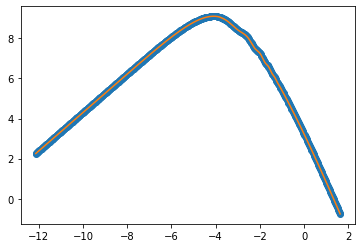

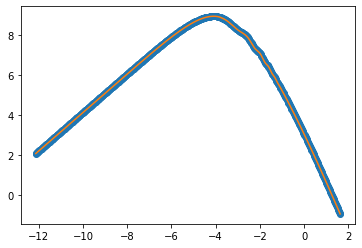

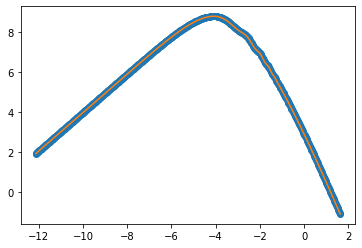

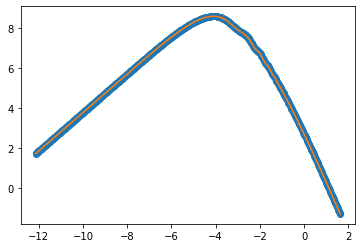

In [521]:
# f and D for each z_mean:
f = [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]
D = [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]

# Based on table 3 of the page 14:
n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
V_s = [7.94, 9.15, 10.05, 16.22]
#galazy bias factor
b = [1.46, 1.61, 1.75, 1.9]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]


Pk_00 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_00.dat")
Pk_01 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_01.dat")
Pk_02 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_02.dat")
Pk_03 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_03.dat")

Pk_ = [Pk_00,Pk_01, Pk_02, Pk_03 ]

# Cubic spline interpolation
k_= np.empty(4, dtype=object)
y_= np.empty(4, dtype=object)
P_dd_ = np.empty(4, dtype=object)
k_new= np.empty(4, dtype=object)
y_new= np.empty(4, dtype=object)
# i recorren los redshifts
for i in range(0,4):
    k_[i] = np.log(Pk_[i][:,0])
    y_[i] = np.log(Pk_[i][:,1] * (Pk_[i][:,2]**2))
    P_dd_[i] = interpolate.interp1d(k_[i], y_[i], kind='cubic')
    k_new[i] = np.log(np.arange(Pk_[i][:,0][0], Pk_[i][:,0][-1], 0.0001))
    y_new[i] = P_dd_[i](k_new[i])
    plt.plot(k_[i], y_[i], 'o', k_new[i], y_new[i], '-')
    plt.show()

def P_dd(k, zi):
    i = z_i.index(zi)
    return P_dd_[i](k)



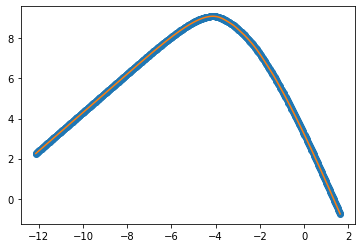

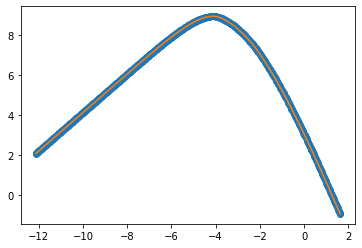

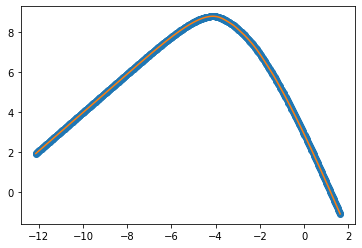

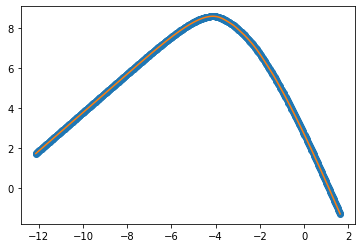

In [522]:
# For Pk_nw (no wiggled power spectrum)
Pk_nw_00 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_00.dat")
Pk_nw_01 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_01.dat")
Pk_nw_02 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_02.dat")
Pk_nw_03 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_03.dat")

Pk_nw = [Pk_nw_00,Pk_nw_01, Pk_nw_02, Pk_nw_03 ]

# Cubic spline interpolation
k_nw= np.empty(4, dtype=object)
y_nw= np.empty(4, dtype=object)
P_nw_ = np.empty(4, dtype=object)
k_nw_new= np.empty(4, dtype=object)
y_nw_new= np.empty(4, dtype=object)
# i recorren los redshifts
for i in range(0,4):
    k_nw[i] = np.log(Pk_nw[i][:,0])
    y_nw[i] = np.log(Pk_nw[i][:,1] * (Pk_nw[i][:,2]**2))
    P_nw_[i] = interpolate.interp1d(k_nw[i], y_nw[i], kind='cubic')
    k_nw_new[i] = np.log(np.arange(Pk_nw[i][:,0][0], Pk_nw[i][:,0][-1], 0.0001))
    y_nw_new[i] = P_nw_[i](k_nw_new[i])
    plt.plot(k_nw[i], y_nw[i], 'o', k_nw_new[i], y_nw_new[i], '-')
    plt.show()

def P_nw(k, zi):
    i = z_i.index(zi)
    return P_nw_[i](k)
        

Obteniendo los datos para las derivadas.

Se define Pk_mn como matriz en la cual sus filas representan un mismo bin y sus columnas representan las derivadas para cada parámetro. 
La derivada para un parámetro corresponde a la posición en la lista param de este parámetro.

In [523]:
param = ['h', 'ns', 'wb', 'wm']

# Derivatives with negative step (mn)
Pk_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_mn[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_mn_eps_1p0E-2\Pk-"+j+"_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

#Ejemplo: Pk_mn[0][1]
#es Pk_mn para el bin 0 y el parámetro ns

# Cubic spline interpolation
k_mn= np.empty((4,4), dtype=object)
y_mn= np.empty((4,4), dtype=object)
P_mn_ = np.empty((4,4), dtype=object)
k_mn_new= np.empty((4,4), dtype=object)
y_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_mn[i][j] = np.log(Pk_mn[i][j][:,0])
        y_mn[i][j] = np.log(Pk_mn[i][j][:,1] * (Pk_mn[i][j][:,2]**2))
        P_mn_[i][j] = interpolate.interp1d(k_mn[i][j], y_mn[i][j], kind='cubic')
        k_mn_new[i][j] = np.log(np.arange(Pk_mn[i][j][:,0][0], Pk_mn[i][j][:,0][-1], 0.0001))
        y_mn_new[i][j] = P_mn_[i][j](k_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_mn(k, zi):
    i = z_i.index(zi)
    return P_mn_[i][j](k)

In [524]:
# Derivatives with positive step (pl)
Pk_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_pl[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_pl_eps_1p0E-2\Pk-"+j+"_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_pl= np.empty((4,4), dtype=object)
y_pl= np.empty((4,4), dtype=object)
P_pl_ = np.empty((4,4), dtype=object)
k_pl_new= np.empty((4,4), dtype=object)
y_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_pl[i][j] = np.log(Pk_pl[i][j][:,0])
        y_pl[i][j] = np.log(Pk_pl[i][j][:,1] * (Pk_pl[i][j][:,2]**2))
        P_pl_[i][j] = interpolate.interp1d(k_pl[i][j], y_pl[i][j], kind='cubic')
        k_pl_new[i][j] = np.log(np.arange(Pk_pl[i][j][:,0][0], Pk_pl[i][j][:,0][-1], 0.0001))
        y_pl_new[i][j] = P_pl_[i][j](k_pl_new[i][j])
        #plt.plot(k_pl[i][j], y_pl[i][j], 'o', k_pl_new[i][j], y_pl_new[i][j], '-')
        #plt.show()

def P_pl(k, zi):
    i = z_i.index(zi)
    return P_pl_[i][j](k)

In [525]:
# Derivatives with negative step (mn)
Pk_nw_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_mn[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_mn_eps_1p0E-2\Pk-nw-" +j+ "_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_mn= np.empty((4,4), dtype=object)
y_nw_mn= np.empty((4,4), dtype=object)
P_nw_mn_ = np.empty((4,4), dtype=object)
k_nw_mn_new= np.empty((4,4), dtype=object)
y_nw_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,0])
        y_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,1] * (Pk_nw_mn[i][j][:,2]**2))
        P_nw_mn_[i][j] = interpolate.interp1d(k_nw_mn[i][j], y_nw_mn[i][j], kind='cubic')
        k_nw_mn_new[i][j] = np.log(np.arange(Pk_nw_mn[i][j][:,0][0], Pk_nw_mn[i][j][:,0][-1], 0.0001))
        y_nw_mn_new[i][j] = P_nw_mn_[i][j](k_nw_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_mn(k, zi):
    i = z_i.index(zi)
    return P_nw_mn_[i][j](k)

In [526]:

# Derivatives with negative step (mn)
Pk_nw_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_pl[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_pl_eps_1p0E-2\Pk-nw-" +j+ "_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_pl= np.empty((4,4), dtype=object)
y_nw_pl= np.empty((4,4), dtype=object)
P_nw_pl_ = np.empty((4,4), dtype=object)
k_nw_pl_new= np.empty((4,4), dtype=object)
y_nw_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,0])
        y_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,1] * (Pk_nw_pl[i][j][:,2]**2))
        P_nw_pl_[i][j] = interpolate.interp1d(k_nw_pl[i][j], y_nw_pl[i][j], kind='cubic')
        k_nw_pl_new[i][j] = np.log(np.arange(Pk_nw_pl[i][j][:,0][0], Pk_nw_pl[i][j][:,0][-1], 0.0001))
        y_nw_pl_new[i][j] = P_nw_pl_[i][j](k_nw_pl_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_pl(k, zi):
    i = z_i.index(zi)
    return P_nw_pl_[i][j](k)

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [527]:
#Fiducial parameters
Om_b0 = 0.022445
h = 0.67
H0 = 100 * h

Om_m0 = 0.143648
n_s = 0.96

c = 300.000

'''
Qué es As10^9?
# Donde se usa? y por qué se especifica el A_s^9
'''
A_s9 = 2.12605
# Reference amplitud As
A_s = 2.1260500000000005e-9
s8_ref = 0.815583

''' 
Cuáles son los non-pyhsical base and physical? y xq la suma no da Om_m?
'''
# Corresponding non-physical base parameters: {Omegab,  Omegac, h, 10^9 As} :> {0.05000000000000001, 0.2671256676696824, 0.67, 2.1260500000000007}
Om_b_np= 0.05000000000000001
Om_c_np = 0.2671256676696824
A_s9 = 2.1260500000000007
# Corresponding physical base parameters: {omegab,  omegac, h, 10^9 As} :> {0.022445000000000007, 0.11991271221692044, 0.67, 2.1260500000000007}
Om_b_p= 0.022445000000000007
Om_c_p = 0.11991271221692044

# Halofit version in CAMB: 4
# Maximum k value in CAMB (h/Mpc): 5
# Numeric CAMB parameters : {AccuracyBoost -> 2, TransferHighPrecision -> True, TransferKperLogInt -> 50}
# Constant Neutrino CAMB parameters : {OmegaNu -> 0.00143717, MasslessNeutrinos -> 2.046, MassiveNeutrinos -> 1, NuMassFractions -> {1}}
Om_nu = 0.00143717

# Defining Om_c
Om_c0 = Om_m0 - Om_b0 - Om_nu

print('Om_m:', Om_m0)
print('physical Om_m:', Om_b_p + Om_c_p + Om_nu)
print('non-physical Om_m:',Om_b_np + Om_c_np + Om_nu)

# np.sqrt(Om_m0 + Om_DE0 + Om_k0) = 1
Om_DE0 = - Om_m0  

m_nu = 0.06
w_0 = -1
w_a = 0

A_surv = 15000
s_z = 0.0001 #Spectroscopic redshift error

P_s = 0

# Defining mu
u = np.linspace(-1, 1, num= len(k_00))

Om_m: 0.143648
physical Om_m: 0.14379488221692044
non-physical Om_m: 0.31856283766968235


In [528]:
# s8 es el mismo para cada z
s8 = np.zeros_like(z_i)
bs8 = np.zeros_like(z_i)
fs8 = np.zeros_like(z_i)
for i in range(0, 4):
        s8[i]= Pk_[i][0,2]
        bs8[i] = b[i]* s8[i]
        fs8[i] = f[i]* s8[i]

In [529]:
def E(z):
    return np.sqrt((Om_m0*(1+z)**(3)) + Om_DE0)

def H_ref(z):
    return H0 * E(z)

def r(z):
    a = 1/E(z)
    return (c/H0) * np.cumsum(a, dtype=float)  

def D_A_ref(z):
    return (1+z)**(-1) * r(z)


In [530]:
# Comoving distance error sr

def F_z(k_ref,u_ref,z):
  return np.exp(-((k_ref* u_ref*c *(1+z)* s_z)/H_ref(z))**2)

def qpar(z, H = None):
  H_value = H_ref(z) if H is None else H
  return H_ref(z)/H_value

def qper(z, D_A = None):
  D_A_value = D_A_ref(z) if D_A is None else D_A
  return D_A_value/ D_A_ref(z)


# To convert the known reference k_ref and mu_ref to the unknown, true k and mu
def k(z, k_ref, u_ref, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return (k_ref /qper1)* (1 + u_ref**2 * ((qper1**2/qpar1**2) -1))**(1/2)

def u(z, k_ref, u_ref, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return u_ref * (qper1/qpar1) * (1 + u_ref**2 * ((qper1**2/qpar1**2) -1))**(-1/2)

# Non-linear damping factor of the BAO signal.
def g_u(u, zi):
  bin = z_i.index(zi)
  return sv[bin]**2 *(1- u**2 + (u**2)*(1+ f[bin])**2)

def P_dw(k_ref, u_ref, z, paso = None, var = None):
  k1= k(z, k_ref, u_ref)
  u1= u(z, k_ref, u_ref)
  if paso == None:
    return P_dd(k1, z)* np.exp(-g_u(u1,z)*k1**2) + P_nw(k1, z)* (1- np.exp(-g_u(u1,z)*k1**2))
  
  elif paso == 'pl':
    return P_pl[var](k1, z)* np.exp(-g_u(u1,z)*k1**2) + P_nw_pl[var](k1, z)* (1- np.exp(-g_u(u1,z)*k1**2))
    
  else:
    return P_mn[var](k1, z)* np.exp(-g_u(u1,z)*k1**2) + P_nw_mn[var](k1, z)* (1- np.exp(-g_u(u1,z)*k1**2))

# In practice:
# sv(z) controls the strength of the non-linear damping of the BAO signal in all directions.
def sv_2_(zi):
  j = z_i.index(zi)
  I = np.trapz(P_dd(k_new[j], zi), k_new[j])
  return (1/(6* (np.pi**2)))* I

def sp_2_(zi):
  return sv_2_(zi)

def sv_(zi):
  return np.sqrt(sv_2_(zi))

def sp_(zi):
  return np.sqrt(sp_2_(zi)) 

sv = [sv_(z_i[0]), sv_(z_i[1]), sv_(z_i[2]), sv_(z_i[3])]
sp = [sp_(z_i[0]), sp_(z_i[1]), sp_(z_i[2]), sp_(z_i[3])]


In [531]:
# Full non-linear model
def P_obs(k_ref, u_ref, zi, bs81=None, fs81=None, f1= None , sp1=None, s81= None, H= None, D_A = None):
  bin = z_i.index(zi)
  bs8_value = bs8[bin] if bs81 is None else bs81
  fs8_value = fs8[bin] if fs81 is None else fs81
  f_value = f[bin] if f1 is None else f1
  sp_value = sp[bin] if sp1 is None else sp1
  s8_value = s8[bin] if s81 is None else s81
  
  H_value = None if H is None else H
  D_A_value = None if D_A is None else D_A
  
  k_eval = k(zi, k_ref, u_ref, H = H_value, D_A = D_A_value)
  u_eval = u(zi, k_ref, u_ref, H = H_value, D_A = D_A_value)

  # Cómo saco la dependencia de H para H_value = None
  return (1/(qpar(zi, H= H_value)**2 * qper(zi, D_A = D_A_value)))*((bs8_value + fs8_value*u_eval**2)**2/(1+(f_value*k_eval*u_eval*sp_value)**2)) * (P_dw(k_eval,u_eval,zi)/s8_value**2)* F_z(k_eval,u_eval,zi) + P_s


def V_eff(zi, k, u):
  bin = z_i.index(zi)
  return V_s[bin] * (n[bin])*P_obs(k,u, zi)/(n[bin]*P_obs(k,u, zi) + 1)**2

In [532]:
# epsilon varía entre los 0.0001 y 0.01
def derivada_ln_P_obs(k_ref, u_ref, z, a, eps =1e-4):
    #h: Tamaño del paso (opcional, por defecto 1e-5)

    bin = z_i.index(z)
    if a == 'Ps':
      ln_P_obs = np.log(P_obs)
      derivada = 1/ ln_P_obs(k_ref, u_ref, z)
    # if are shape parameters w_b0 , h, w_m0 , n_s
    elif a == 'wb' or a== 'h' or a == 'wm' or a == 'ns':
      # str to function
      a1= globals().get(a)
      for j in range(0,4):
        if a == param[j]:
          var = j
          
      derivada = (np.log(P_dw(k_ref, u_ref, z, a1 = a1[bin]*(1+ eps), paso = 'pl', var = var)/s8[bin]**2)- np.log(P_dw(k_ref, u_ref, z, a1 = a1[bin] *(1-eps), paso = 'mn', var = var)/s8[bin]**2) )/ (2 * eps* a1)

    # if are non-linear parameters sv y sp
    #three-point stencil derivative of f with respect to x at x0
    elif a == 'sv':
      derivada = (np.log(P_dw(k_ref, u_ref, z, sv = sv[bin]*(1+ eps))/ s8[bin]**2)- np.log(P_dw(k_ref, u_ref, z, sv = sv[bin]*(1 - eps))/ s8[bin]**2)) / (2 * eps * np.log(P_dw(k_ref, u_ref, z, sv = sv)/ s8[bin]**2))

    elif a == 'sp':
      k1= k(z, k_ref, u_ref)
      u1= u(z, k_ref, u_ref)
      derivada = (np.log(1/ (1+(f[bin]*k1*u1*sp[bin]*(1+ eps))**2))- np.log(1/ (1+(f[bin]*k1*u1*sp[bin]*(1- eps))**2))) / (2 * eps * np.log(1/ (1+(f[bin]*k1*u1*sp[bin])**2)))

    # if parameters are fs8 and bs8
    elif a == 'fs8':
      derivada = (np.log(P_obs(k_ref, u_ref, z, fs81 = fs8[bin]**(1 + eps))) - np.log(P_obs(k_ref, u_ref, z, fs81 = fs8[bin]**(1 - eps)))) / (2* eps * np.log(fs8[bin]))

    elif a == 'bs8':
      derivada = (np.log(P_obs(k_ref, u_ref, z, bs81 = bs8[bin]**(1 + eps))) - np.log(P_obs(k_ref, u_ref, z, bs81 = bs8[bin]**(1 - eps)))) / (2* eps * np.log(bs8[bin]))


    elif a == 'H':
      derivada = 8* (np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1+ eps)))- np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1- eps))))/(12* eps * np.log(H_ref(z))) - (np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1+ 2*eps)))- np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1 - 2*eps))))/(12* eps * np.log(H_ref(z)))
    elif a == 'D_A':
      derivada = 8* (np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1+ eps)))- np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1- eps))))/(12* eps * np.log(D_A_ref(z))) - (np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1+ 2*eps)))- np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1 - 2*eps))))/(12* eps * np.log(D_A_ref(z)))

    return derivada



Se definen funciones para transformar los puntos $\mu_{ref}$ a $\mu$ y $k_{ref}$ a $k$ debido a los efectos AP.
Estas relaciones son:
$$ 
\mu_{ref} = \frac{k \mu^2}{q_\perp} 
$$
$$
k_{ref} = k q_{\perp}
$$

In [549]:
''' 
Están bien?
'''
def u_ref_u(z, k, u, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return (k * (u**2))/ qper1

def k_ref_k(z, k, u, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return k * qper1

def double_integral(func, u_range, k_range, num_intervals_u, num_intervals_k, zi, a, b):
    # Crea una malla de puntos en el plano de integración
    u_vals = np.linspace(u_range[0], u_range[1], num_intervals_u)
    k_vals = np.linspace(k_range[0], k_range[1], num_intervals_k)
    du = u_vals[1] - u_vals[0]
    dk = k_vals[1] - k_vals[0]

    # Evalúa la función en cada punto de la malla
    z_vals = np.zeros((num_intervals_u, num_intervals_k))
    u_ref_vals = np.zeros(num_intervals_u)
    k_ref_vals = np.zeros(num_intervals_k)
    for i in range(num_intervals_u):
        for j in range(num_intervals_k):
      
            # Transformando los parámetros mu y k
            u_ref_vals[i] = u_ref_u(zi, k_vals[j], u_vals[i])
            k_ref_vals[j] = k_ref_k(zi, k_vals[j], u_vals[i])
            z_vals[i, j] = func(u_ref_vals[i], k_ref_vals[j], zi, a, b)

    # Integra a lo largo del eje y (primera integral)
    integral_k = np.trapz(z_vals, x=u_vals, axis=0)
    # Integra a lo largo del eje x (segunda integral)
    integral = np.trapz(integral_k, x=k_vals)

    return integral

# Ejemplo de una función para integrar
def func_to_integrate(u_ref, k_ref, zi, a, b):
  return k(zi, k_ref, u_ref)**2 * derivada_ln_P_obs(k_ref, u_ref, zi, a) *derivada_ln_P_obs(k_ref, u_ref, zi, b)* V_eff(zi, k_ref, u_ref)

# Define los límites de integración y el número de intervalos en cada dimensión

#Pessimistic setting
x_range = [0.001, 0.25]
y_range = [-1, 1]
num_intervals_x = 100
num_intervals_y = 100


In [550]:
# Calcula la integral doble numéricamente
a = 'bs8'
b = 'bs8'
result = double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[0], a, b)
print("Resultado de la integral doble para el bin 0:", result)

Resultado de la integral doble para el bin 0: 0.02401220673175492


In [547]:
# Pruebas
a = 'H'
b = 'D_A'
result = double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[0], a, b)
print("Resultado de la integral doble para el bin 0:", result)


Resultado de la integral doble para el bin 0: -0.011436827388290301


¿Cómo sé si está bien? Me dió negativo con a= H y b= D_A
Por qué se demora tanto?

In [ ]:
# def D_A_ref(z):
#     if Om_k0 < 0:
#         return (1+z)**(-1) * (c/H0) * (1/ np.sqrt(-Om_k0))* np.sin(np.sqrt(-Om_k0) * (H0/c) * r(z))
#     elif Om_k0 == 0:
#         return (1+z)**(-1) * r(z)
#     else:
#         return (1+z)**(-1) * (c/H0) * (1/ np.sqrt(Om_k0))* np.sinh(np.sqrt(Om_k0) * (H0/c) * r(z))